In [67]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from simple_vector_db.quantization.vector_quantizer import VectorQuantizer
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
import pandas as pd
import psutil
import sys
import seaborn as sns

In [69]:
vectors_to_quantize = load_digits().data

In [70]:
m_chunks_list = range(2, 32, 2)
res = []
for m_chunk in m_chunks_list:
    k_centroids_list = np.array(range(2, 32, 2)) * m_chunk
    for k_centroids in k_centroids_list:
        try:
            quantizer = VectorQuantizer(m_chunks=m_chunk, k_centroids=k_centroids)
            quantized_vectors = quantizer.quantize_vectors(vectors_to_quantize)
            print(m_chunk, k_centroids, (vectors_to_quantize.size * vectors_to_quantize.itemsize) / 1024,
                  (quantized_vectors.size * quantized_vectors.itemsize) / 1024)
            rebuilt_vector = quantizer.rebuild_vector(quantized_vectors[0])
            compression_mse = mean_squared_error(vectors_to_quantize[0], rebuilt_vector)
            res.append({"m_chunk": m_chunk, "k_centroids": k_centroids, "mse": compression_mse,
                        "memory_kB": (quantized_vectors.size * quantized_vectors.itemsize) / 1024})
        except ValueError:
            print(m_chunk, k_centroids, "ERROR")

res = pd.DataFrame(res)

<class 'numpy.uint8'>
2 4 898.5 3.509765625
<class 'numpy.uint8'>
2 8 898.5 3.509765625
<class 'numpy.uint8'>
2 12 898.5 3.509765625
<class 'numpy.uint8'>
2 16 898.5 3.509765625
<class 'numpy.uint8'>
2 20 898.5 3.509765625
<class 'numpy.uint8'>
2 24 898.5 3.509765625
<class 'numpy.uint8'>
2 28 898.5 3.509765625
<class 'numpy.uint8'>
2 32 898.5 3.509765625
<class 'numpy.uint8'>
2 36 898.5 3.509765625
<class 'numpy.uint8'>
2 40 898.5 3.509765625
<class 'numpy.uint8'>
2 44 898.5 3.509765625
<class 'numpy.uint8'>
2 48 898.5 3.509765625
<class 'numpy.uint8'>
2 52 898.5 3.509765625
<class 'numpy.uint8'>
2 56 898.5 3.509765625
<class 'numpy.uint8'>
2 60 898.5 3.509765625
<class 'numpy.uint8'>
4 8 898.5 7.01953125
<class 'numpy.uint8'>
4 16 898.5 7.01953125
<class 'numpy.uint8'>
4 24 898.5 7.01953125
<class 'numpy.uint8'>
4 32 898.5 7.01953125
<class 'numpy.uint8'>
4 40 898.5 7.01953125
<class 'numpy.uint8'>
4 48 898.5 7.01953125
<class 'numpy.uint8'>
4 56 898.5 7.01953125
<class 'numpy.uint8'

In [71]:
res

,m_chunk,k_centroids,mse,memory_kB
0,2,4,11.666371,3.509766
1,2,8,9.016660,3.509766
2,2,12,4.053078,3.509766
3,2,16,3.006581,3.509766
4,2,20,3.038386,3.509766
5,2,24,3.143916,3.509766
6,2,28,3.127255,3.509766
7,2,32,2.815170,3.509766
8,2,36,2.807794,3.509766
9,2,40,2.846483,3.509766


<Axes: xlabel='k_centroids', ylabel='mse'>

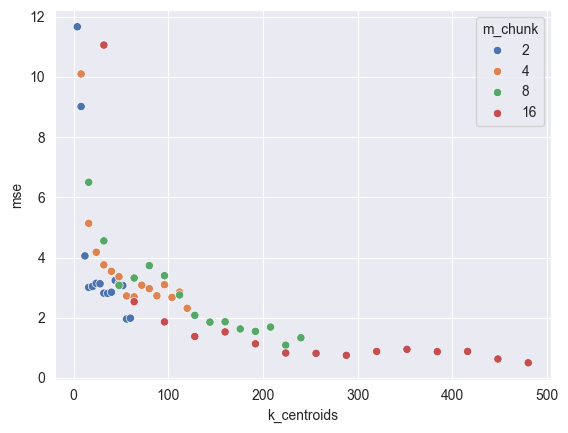

In [72]:
#sns.kdeplot(data = res,x = "m_chunk", y = 'k_centroids',hue = "mse", fill = True)
colors = ["#FF0B04", "#4374B3"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.scatterplot(data=res, x="k_centroids", y="mse", hue="m_chunk", palette="deep")

<Axes: xlabel='k_centroids', ylabel='memory_kB'>

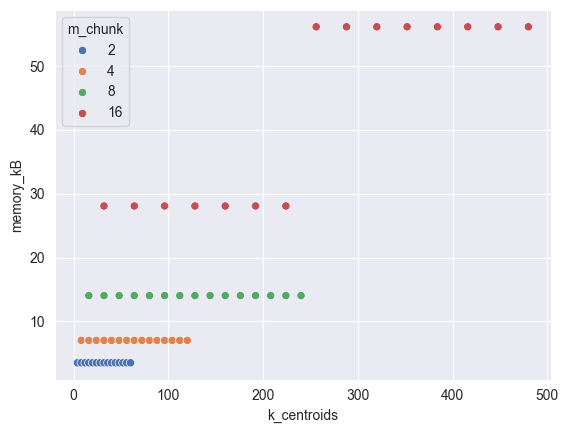

In [73]:
sns.scatterplot(data=res, x="k_centroids", y="memory_kB", hue="m_chunk", palette="deep")